In [7]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the dataset
file_path = '/home/szy/proj/crf/CDK9/CDK9.csv'
data = pd.read_csv(file_path)

# Function to compute RDKit fingerprint
def compute_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    else:
        return None

# Filter out invalid molecules
data['fingerprint'] = data['smiles'].apply(compute_fingerprint)
data = data.dropna(subset=['fingerprint'])

# Convert fingerprints to numpy array
X = np.array([fp.ToBitString() for fp in data['fingerprint']])
X = np.array([list(map(int, list(x))) for x in X])

# Target variable
y = data['pIC50'].astype(float)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold} - RMSE: {rmse}, R²: {r2}")

mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

# Print the mean results
print(f"Mean RMSE: {mean_rmse}")
print(f"Mean R²: {mean_r2}")

# Save the results to a CSV file
results = pd.DataFrame({"RMSE": rmse_scores, "R2": r2_scores})
results.to_csv('cross_validation_results.csv', index=False)


[20:54:34] SMILES Parse Error: syntax error while parsing: 0
[20:54:34] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Fold 1 - RMSE: 0.700685583054433, R²: 0.5130806853863097
Fold 2 - RMSE: 0.6339969970608723, R²: 0.5934930363477608
Fold 3 - RMSE: 0.562438525759548, R²: 0.6923433625812048
Fold 4 - RMSE: 0.7657679545768021, R²: 0.4556549087321653
Fold 5 - RMSE: 0.7731874893947597, R²: 0.3245826421921171
Mean RMSE: 0.6872153099692829
Mean R²: 0.5158309270479116


[20:40:54] SMILES Parse Error: syntax error while parsing: 0
[20:40:54] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Cross-Validation R² scores: [-0.11335818 -0.0865394  -0.09231473 -0.49414636 -0.41674159]
Mean Cross-Validation R²: -0.24062005050761845
Standard Deviation Cross-Validation R²: 0.17732754255451308
Cross-Validation RMSE scores: [1.46103768 0.45769569 0.69542567 0.94072751 1.40058124]
Mean Cross-Validation RMSE: 0.9910935589616919
Standard Deviation Cross-Validation RMSE: 0.39063977374944614
Test R² score:  0.49965462452527776
Test RMSE: 0.7102800650592909


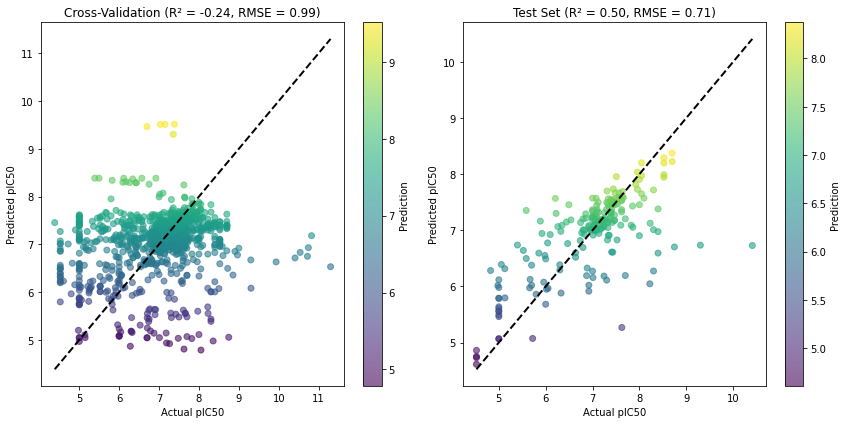

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(30)

# Load CSV file
df = pd.read_csv('/home/szy/proj/crf/CDK9/CDK9.csv')

# Convert SMILES strings to molecular objects
ms = [Chem.MolFromSmiles(x) for x in df['smiles']]

# Filter out invalid molecules
valid_mols = [mol for mol in ms if mol is not None]
valid_indices = [i for i, mol in enumerate(ms) if mol is not None]
df = df.iloc[valid_indices]

# Create new column for RDKit fingerprints
df['RDKit_FP'] = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in valid_mols]

# Save fingerprints and labels
with open('rdkit_fingerprints.pkl', 'wb') as f:
    pickle.dump(df['RDKit_FP'].values, f)
with open('labels.pkl', 'wb') as f:
    pickle.dump(df['pIC50'].values, f)

# Load fingerprints and labels
with open('rdkit_fingerprints.pkl', 'rb') as f:
    rdkit_fingerprints = pickle.load(f)
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

# Convert fingerprints to numpy array
rdkit_fingerprints = np.array(list(rdkit_fingerprints))

# Train Random Forest model with 5-fold cross-validation
model = RandomForestRegressor(random_state=42)

# Define R² as scoring metric
r2_scorer = make_scorer(r2_score)

# Perform cross-validation and print results
cv_r2_scores = cross_val_score(model, rdkit_fingerprints, labels, cv=5, scoring=r2_scorer)
print(f"Cross-Validation R² scores: {cv_r2_scores}")
print(f"Mean Cross-Validation R²: {np.mean(cv_r2_scores)}")
print(f"Standard Deviation Cross-Validation R²: {np.std(cv_r2_scores)}")

# Define RMSE as scoring metric
rmse_scorer = make_scorer(mean_squared_error, squared=False)
cv_rmse_scores = cross_val_score(model, rdkit_fingerprints, labels, cv=5, scoring=rmse_scorer)
print(f"Cross-Validation RMSE scores: {cv_rmse_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(cv_rmse_scores)}")
print(f"Standard Deviation Cross-Validation RMSE: {np.std(cv_rmse_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(model, rdkit_fingerprints, labels, cv=5)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(rdkit_fingerprints, labels, test_size=0.2, random_state=42)

# Train final model on the entire training set
model.fit(X_train, y_train)

# Save the trained model
with open('RandomForest_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Predict on test set
predictions = model.predict(X_test)

# Calculate and print test set R² score and RMSE
test_r2 = r2_score(y_test, predictions)
print("Test R² score: ", test_r2)
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse_test}")

# Plotting
plt.figure(figsize=(12, 6))

# Cross-validation plot
plt.subplot(1, 2, 1)
plt.scatter(labels, cv_predictions, c=cv_predictions, cmap='viridis', alpha=0.6)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Cross-Validation (R² = {np.mean(cv_r2_scores):.2f}, RMSE = {np.mean(cv_rmse_scores):.2f})')
plt.colorbar(label='Prediction')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, c=predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {test_r2:.2f}, RMSE = {rmse_test:.2f})')
plt.colorbar(label='Prediction')

plt.tight_layout()
plt.show()


[17:13:15] SMILES Parse Error: syntax error while parsing: 0
[17:13:15] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Cross-Validation RMSE scores: [0.69817506 0.60629208 0.80788459 0.7104691  0.74950887]
Mean Cross-Validation RMSE: 0.714465939523399
Standard Deviation Cross-Validation RMSE: 0.06623896292916677
Cross-Validation R² score: 0.483722624104614
Test R^2 score:  0.5710490369193513
Test RMSE: 0.6576555725069176


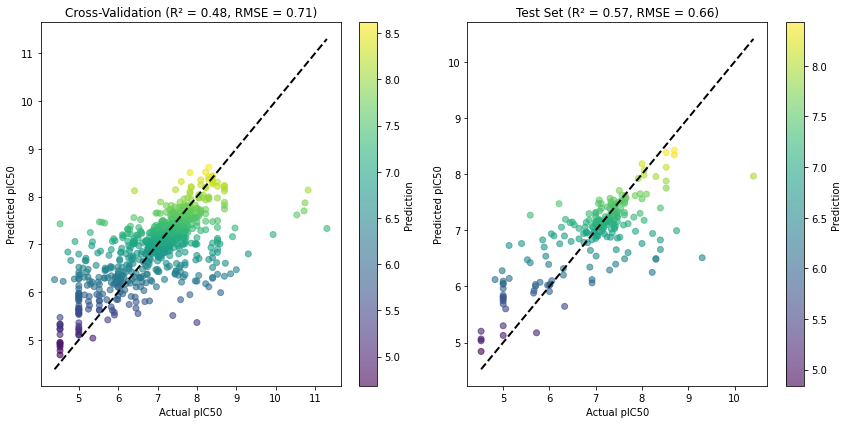

Loaded model test R^2 score: 0.5710490369193513
Loaded model test RMSE: 0.6576555725069176


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(30)

# 读取CSV文件
df = pd.read_csv('/home/szy/proj/crf/CDK9/CDK9.csv')

# 将SMILES字符串转换为分子对象
ms = [Chem.MolFromSmiles(x) for x in df['smiles']]

# 过滤掉无效的分子
valid_mols = [mol for mol in ms if mol is not None]
valid_indices = [i for i, mol in enumerate(ms) if mol is not None]
df = df.iloc[valid_indices]

# 创建新列来保存RDKit指纹
df['RDKit_FP'] = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in valid_mols]

with open('rdkit_fingerprints.pkl', 'wb') as f:
    pickle.dump(df['RDKit_FP'].values, f)

# Save labels
with open('labels.pkl', 'wb') as f:
    pickle.dump(df['pIC50'].values, f)

with open('rdkit_fingerprints.pkl', 'rb') as f:
    rdkit_fingerprints = pickle.load(f)

# Load labels
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

rdkit_fingerprints = np.array(list(rdkit_fingerprints))

# Split to separate out the training and test set
X_train, X_test, y_train, y_test = train_test_split(rdkit_fingerprints, labels, test_size=0.2, random_state=42)

# Train SVR model with 5-fold cross-validation
model = SVR(kernel='rbf')

# Define RMSE as scoring metric
scoring = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and print results
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
print(f"Cross-Validation RMSE scores: {cv_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(cv_scores)}")
print(f"Standard Deviation Cross-Validation RMSE: {np.std(cv_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate R^2 score
cv_r2 = r2_score(y_train, cv_predictions)
print(f"Cross-Validation R² score: {cv_r2}")

# Train final model on the entire training set
model.fit(X_train, y_train)

# Save the model using pickle
with open('svr_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Predict on test set
predictions = model.predict(X_test)

# Calculate and print test set R^2 score
test_r2 = r2_score(y_test, predictions)
print("Test R^2 score: ", test_r2)

# Calculate and print test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse_test}")

# Plotting
plt.figure(figsize=(12, 6))

# Cross-validation plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, cv_predictions, c=cv_predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Cross-Validation (R² = {cv_r2:.2f}, RMSE = {np.mean(cv_scores):.2f})')
plt.colorbar(label='Prediction')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, c=predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {test_r2:.2f}, RMSE = {rmse_test:.2f})')
plt.colorbar(label='Prediction')

plt.tight_layout()
plt.show()

# Load the model using pickle (if needed)
with open('svr_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify loaded model predictions
loaded_predictions = loaded_model.predict(X_test)
print(f"Loaded model test R^2 score: {r2_score(y_test, loaded_predictions)}")
print(f"Loaded model test RMSE: {np.sqrt(mean_squared_error(y_test, loaded_predictions))}")


/home/szy/anaconda3/envs/qsar/lib/python3.7/site-packages/pkg_resources/__init__.py:126: PkgResourcesDeprecationWarning: refs-pull-327-head is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,
[17:14:33] SMILES Parse Error: syntax error while parsing: 0
[17:14:33] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Cross-Validation RMSE scores: [0.7291726  0.61350991 0.75827818 0.71583806 0.80402116]
Mean Cross-Validation RMSE: 0.7241639836247987
Standard Deviation Cross-Validation RMSE: 0.06305501973375037
Cross-Validation R² score: 0.47014483161776155
Test R^2 score:  0.5304321809051731
Test RMSE: 0.6880877776213356


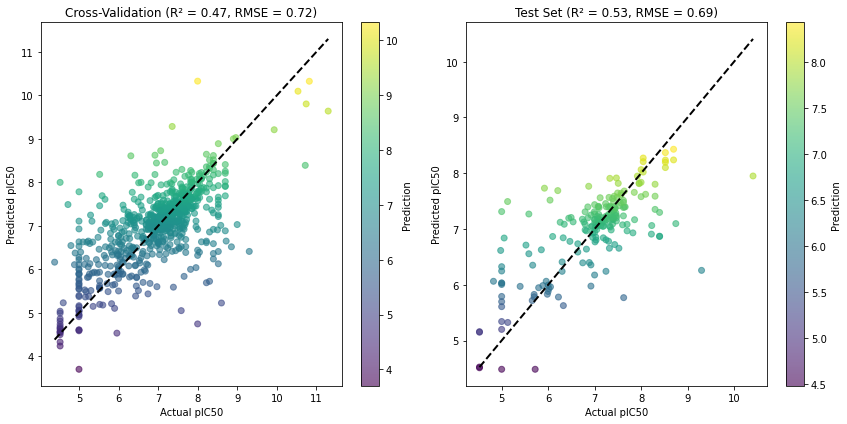

Loaded model test R^2 score: 0.5304321809051731
Loaded model test RMSE: 0.6880877776213356


In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Set random seed
np.random.seed(30)

# 读取CSV文件
df = pd.read_csv('/home/szy/proj/crf/CDK9/CDK9.csv')

# 将SMILES字符串转换为分子对象
ms = [Chem.MolFromSmiles(x) for x in df['smiles']]

# 过滤掉无效的分子
valid_mols = [mol for mol in ms if mol is not None]
valid_indices = [i for i, mol in enumerate(ms) if mol is not None]
df = df.iloc[valid_indices]

# 创建新列来保存RDKit指纹
df['RDKit_FP'] = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in valid_mols]

with open('rdkit_fingerprints.pkl', 'wb') as f:
    pickle.dump(df['RDKit_FP'].values, f)

# Save labels
with open('labels.pkl', 'wb') as f:
    pickle.dump(df['pIC50'].values, f)

with open('rdkit_fingerprints.pkl', 'rb') as f:
    rdkit_fingerprints = pickle.load(f)

# Load labels
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

rdkit_fingerprints = np.array(list(rdkit_fingerprints))

# Split to separate out the training and test set
X_train, X_test, y_train, y_test = train_test_split(rdkit_fingerprints, labels, test_size=0.2, random_state=42)

# Train XGBoost model with 5-fold cross-validation
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define RMSE as scoring metric
scoring = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and print results
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
print(f"Cross-Validation RMSE scores: {cv_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(cv_scores)}")
print(f"Standard Deviation Cross-Validation RMSE: {np.std(cv_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate R^2 score
cv_r2 = r2_score(y_train, cv_predictions)
print(f"Cross-Validation R² score: {cv_r2}")

# Train final model on the entire training set
model.fit(X_train, y_train)

# Save the model using pickle
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Predict on test set
predictions = model.predict(X_test)

# Calculate and print test set R^2 score
test_r2 = r2_score(y_test, predictions)
print("Test R^2 score: ", test_r2)

# Calculate and print test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse_test}")

# Plotting
plt.figure(figsize=(12, 6))

# Cross-validation plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, cv_predictions, c=cv_predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Cross-Validation (R² = {cv_r2:.2f}, RMSE = {np.mean(cv_scores):.2f})')
plt.colorbar(label='Prediction')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, c=predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {test_r2:.2f}, RMSE = {rmse_test:.2f})')
plt.colorbar(label='Prediction')

plt.tight_layout()
plt.show()

# Load the model using pickle (if needed)
with open('xgboost_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify loaded model predictions
loaded_predictions = loaded_model.predict(X_test)
print(f"Loaded model test R^2 score: {r2_score(y_test, loaded_predictions)}")
print(f"Loaded model test RMSE: {np.sqrt(mean_squared_error(y_test, loaded_predictions))}")


[17:17:33] SMILES Parse Error: syntax error while parsing: 0
[17:17:33] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Cross-Validation RMSE scores: [0.87915284 0.83651668 0.90211371 0.94527033 1.01315474]
Mean Cross-Validation RMSE: 0.9152416589677864
Standard Deviation Cross-Validation RMSE: 0.06026783794450803
Cross-Validation R² score: 0.15636671986829598
Test R^2 score:  0.3003325755449554
Test RMSE: 0.8399249996683957


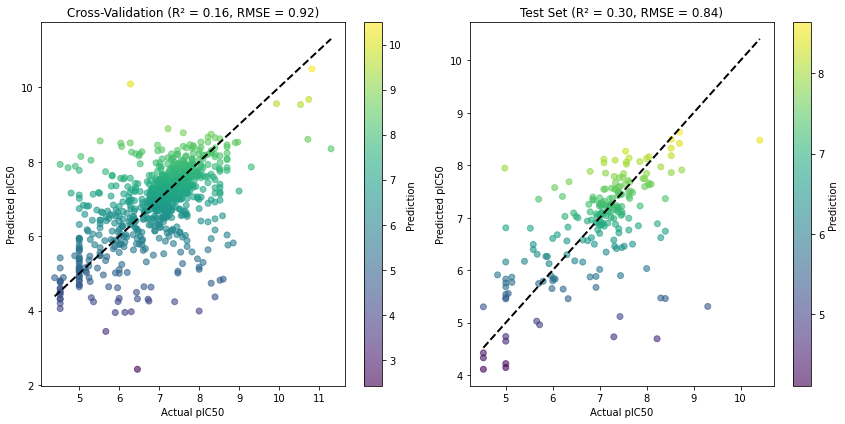

Loaded model test R^2 score: 0.3003325755449554
Loaded model test RMSE: 0.8399249996683957


In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(30)

# 读取CSV文件
df = pd.read_csv('/home/szy/proj/crf/CDK9/CDK9.csv')

# 将SMILES字符串转换为分子对象
ms = [Chem.MolFromSmiles(x) for x in df['smiles']]

# 过滤掉无效的分子
valid_mols = [mol for mol in ms if mol is not None]
valid_indices = [i for i, mol in enumerate(ms) if mol is not None]
df = df.iloc[valid_indices]

# 创建新列来保存RDKit指纹
df['RDKit_FP'] = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in valid_mols]

with open('rdkit_fingerprints.pkl', 'wb') as f:
    pickle.dump(df['RDKit_FP'].values, f)

# Save labels
with open('labels.pkl', 'wb') as f:
    pickle.dump(df['pIC50'].values, f)

with open('rdkit_fingerprints.pkl', 'rb') as f:
    rdkit_fingerprints = pickle.load(f)

# Load labels
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

rdkit_fingerprints = np.array(list(rdkit_fingerprints))

# Split to separate out the training and test set
X_train, X_test, y_train, y_test = train_test_split(rdkit_fingerprints, labels, test_size=0.2, random_state=42)

# Train MLP model with 5-fold cross-validation
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)

# Define RMSE as scoring metric
scoring = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and print results
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
print(f"Cross-Validation RMSE scores: {cv_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(cv_scores)}")
print(f"Standard Deviation Cross-Validation RMSE: {np.std(cv_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate R^2 score
cv_r2 = r2_score(y_train, cv_predictions)
print(f"Cross-Validation R² score: {cv_r2}")

# Train final model on the entire training set
model.fit(X_train, y_train)

# Save the model using pickle
with open('mlp_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Predict on test set
predictions = model.predict(X_test)

# Calculate and print test set R^2 score
test_r2 = r2_score(y_test, predictions)
print("Test R^2 score: ", test_r2)

# Calculate and print test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse_test}")

# Plotting
plt.figure(figsize=(12, 6))

# Cross-validation plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, cv_predictions, c=cv_predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Cross-Validation (R² = {cv_r2:.2f}, RMSE = {np.mean(cv_scores):.2f})')
plt.colorbar(label='Prediction')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, c=predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {test_r2:.2f}, RMSE = {rmse_test:.2f})')
plt.colorbar(label='Prediction')

plt.tight_layout()
plt.show()

# Load the model using pickle (if needed)
with open('mlp_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify loaded model predictions
loaded_predictions = loaded_model.predict(X_test)
print(f"Loaded model test R^2 score: {r2_score(y_test, loaded_predictions)}")
print(f"Loaded model test RMSE: {np.sqrt(mean_squared_error(y_test, loaded_predictions))}")


[17:19:10] SMILES Parse Error: syntax error while parsing: 0
[17:19:10] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Cross-Validation RMSE scores: [0.71478624 0.64981916 0.73377146 0.68961682 0.78450306]
Mean Cross-Validation RMSE: 0.7144993493966318
Standard Deviation Cross-Validation RMSE: 0.044888047469600095
Cross-Validation R² score: 0.48605399531702353
Test R^2 score:  0.49937992399433206
Test RMSE: 0.7104750179332453


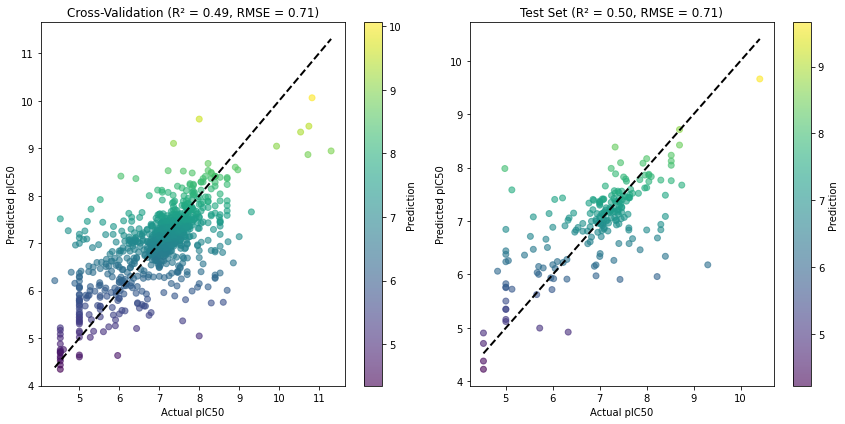

Loaded model test R^2 score: 0.49937992399433206
Loaded model test RMSE: 0.7104750179332453


In [7]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(30)

# 读取CSV文件
df = pd.read_csv('/home/szy/proj/crf/CDK9/CDK9.csv')

# 将SMILES字符串转换为分子对象
ms = [Chem.MolFromSmiles(x) for x in df['smiles']]

# 过滤掉无效的分子
valid_mols = [mol for mol in ms if mol is not None]
valid_indices = [i for i, mol in enumerate(ms) if mol is not None]
df = df.iloc[valid_indices]

# 创建新列来保存RDKit指纹
df['RDKit_FP'] = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in valid_mols]

with open('rdkit_fingerprints.pkl', 'wb') as f:
    pickle.dump(df['RDKit_FP'].values, f)

# Save labels
with open('labels.pkl', 'wb') as f:
    pickle.dump(df['pIC50'].values, f)

with open('rdkit_fingerprints.pkl', 'rb') as f:
    rdkit_fingerprints = pickle.load(f)

# Load labels
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

rdkit_fingerprints = np.array(list(rdkit_fingerprints))

# Split to separate out the training and test set
X_train, X_test, y_train, y_test = train_test_split(rdkit_fingerprints, labels, test_size=0.2, random_state=42)

# Train Bayesian Ridge model with 5-fold cross-validation
model = BayesianRidge()

# Define RMSE as scoring metric
scoring = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and print results
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
print(f"Cross-Validation RMSE scores: {cv_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(cv_scores)}")
print(f"Standard Deviation Cross-Validation RMSE: {np.std(cv_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate R^2 score
cv_r2 = r2_score(y_train, cv_predictions)
print(f"Cross-Validation R² score: {cv_r2}")

# Train final model on the entire training set
model.fit(X_train, y_train)

# Save the model using pickle
with open('bayesian_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Predict on test set
predictions = model.predict(X_test)

# Calculate and print test set R^2 score
test_r2 = r2_score(y_test, predictions)
print("Test R^2 score: ", test_r2)

# Calculate and print test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse_test}")

# Plotting
plt.figure(figsize=(12, 6))

# Cross-validation plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, cv_predictions, c=cv_predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Cross-Validation (R² = {cv_r2:.2f}, RMSE = {np.mean(cv_scores):.2f})')
plt.colorbar(label='Prediction')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, c=predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {test_r2:.2f}, RMSE = {rmse_test:.2f})')
plt.colorbar(label='Prediction')

plt.tight_layout()
plt.show()

# Load the model using pickle (if needed)
with open('bayesian_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify loaded model predictions
loaded_predictions = loaded_model.predict(X_test)
print(f"Loaded model test R^2 score: {r2_score(y_test, loaded_predictions)}")
print(f"Loaded model test RMSE: {np.sqrt(mean_squared_error(y_test, loaded_predictions))}")


[17:23:30] SMILES Parse Error: syntax error while parsing: 0
[17:23:30] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Cross-Validation RMSE scores: [0.7390176  0.6091724  0.8162138  0.73289974 0.76585514]
Mean Cross-Validation RMSE: 0.7326317356501356
Standard Deviation Cross-Validation RMSE: 0.06837077340004523
Cross-Validation R² score: 0.4570742619798748
Test R^2 score:  0.45931025482750176
Test RMSE: 0.7383609962524573


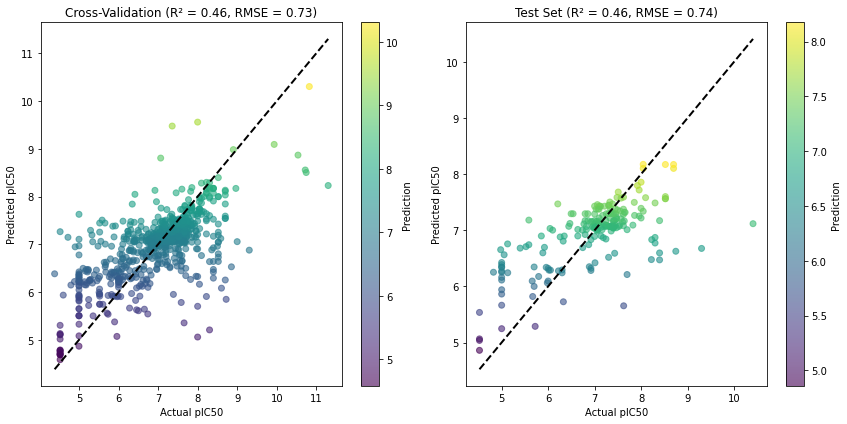

Loaded model test R^2 score: 0.45931025482750176
Loaded model test RMSE: 0.7383609962524573


In [9]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(30)

# 读取CSV文件
df = pd.read_csv('/home/szy/proj/crf/CDK9/CDK9.csv')

# 将SMILES字符串转换为分子对象
ms = [Chem.MolFromSmiles(x) for x in df['smiles']]

# 过滤掉无效的分子
valid_mols = [mol for mol in ms if mol is not None]
valid_indices = [i for i, mol in enumerate(ms) if mol is not None]
df = df.iloc[valid_indices]

# 创建新列来保存RDKit指纹
df['RDKit_FP'] = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in valid_mols]

with open('rdkit_fingerprints.pkl', 'wb') as f:
    pickle.dump(df['RDKit_FP'].values, f)

# Save labels
with open('labels.pkl', 'wb') as f:
    pickle.dump(df['pIC50'].values, f)

with open('rdkit_fingerprints.pkl', 'rb') as f:
    rdkit_fingerprints = pickle.load(f)

# Load labels
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

rdkit_fingerprints = np.array(list(rdkit_fingerprints))

# Split to separate out the training and test set
X_train, X_test, y_train, y_test = train_test_split(rdkit_fingerprints, labels, test_size=0.2, random_state=42)

# Train Gradient Boosting Regressor model with 5-fold cross-validation
model = GradientBoostingRegressor(random_state=42)

# Define RMSE as scoring metric
scoring = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and print results
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
print(f"Cross-Validation RMSE scores: {cv_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(cv_scores)}")
print(f"Standard Deviation Cross-Validation RMSE: {np.std(cv_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate R^2 score
cv_r2 = r2_score(y_train, cv_predictions)
print(f"Cross-Validation R² score: {cv_r2}")

# Train final model on the entire training set
model.fit(X_train, y_train)

# Save the model using pickle
with open('gbr_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Predict on test set
predictions = model.predict(X_test)

# Calculate and print test set R^2 score
test_r2 = r2_score(y_test, predictions)
print("Test R^2 score: ", test_r2)

# Calculate and print test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse_test}")

# Plotting
plt.figure(figsize=(12, 6))

# Cross-validation plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, cv_predictions, c=cv_predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Cross-Validation (R² = {cv_r2:.2f}, RMSE = {np.mean(cv_scores):.2f})')
plt.colorbar(label='Prediction')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, c=predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {test_r2:.2f}, RMSE = {rmse_test:.2f})')
plt.colorbar(label='Prediction')

plt.tight_layout()
plt.show()

# Load the model using pickle (if needed)
with open('gbr_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify loaded model predictions
loaded_predictions = loaded_model.predict(X_test)
print(f"Loaded model test R^2 score: {r2_score(y_test, loaded_predictions)}")
print(f"Loaded model test RMSE: {np.sqrt(mean_squared_error(y_test, loaded_predictions))}")


In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the dataset
file_path = '/home/szy/proj/crf/CDK9/CDK9.csv'
data = pd.read_csv(file_path)

# Function to compute RDKit fingerprint
def compute_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    else:
        return None

# Filter out invalid molecules
data['fingerprint'] = data['smiles'].apply(compute_fingerprint)
data = data.dropna(subset=['fingerprint'])

# Convert fingerprints to numpy array
X = np.array([fp.ToBitString() for fp in data['fingerprint']])
X = np.array([list(map(int, list(x))) for x in X])

# Target variable
y = data['pIC50'].astype(float)

# Initialize the LightGBM Regressor
lgbm = LGBMRegressor(random_state=42)

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold} - RMSE: {rmse}, R²: {r2}")

mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

# Print the mean results
print(f"Mean RMSE: {mean_rmse}")
print(f"Mean R²: {mean_r2}")

# Save the results to a CSV file
results = pd.DataFrame({"RMSE": rmse_scores, "R2": r2_scores})
results.to_csv('cross_validation_results.csv', index=False)


[20:58:54] SMILES Parse Error: syntax error while parsing: 0
[20:58:54] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Fold 1 - RMSE: 0.6733248892618078, R²: 0.5503651393372926
Fold 2 - RMSE: 0.6697117553881249, R²: 0.5464037742631164
Fold 3 - RMSE: 0.5606708742933093, R²: 0.6942741518065316
Fold 4 - RMSE: 0.7048168300591495, R²: 0.5388603494266286
Fold 5 - RMSE: 0.7622936880997035, R²: 0.3434811070510658
Mean RMSE: 0.674163607420419
Mean R²: 0.534676904376927


[17:26:38] SMILES Parse Error: syntax error while parsing: 0
[17:26:38] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Cross-Validation RMSE scores: [0.74316326 0.58847133 0.7171768  0.73973586 0.69078297]
Mean Cross-Validation RMSE: 0.695866044661197
Standard Deviation Cross-Validation RMSE: 0.056877407961246705
Cross-Validation R² score: 0.5111831765331413
Test R^2 score:  0.5934990180966292
Test RMSE: 0.640214461859286


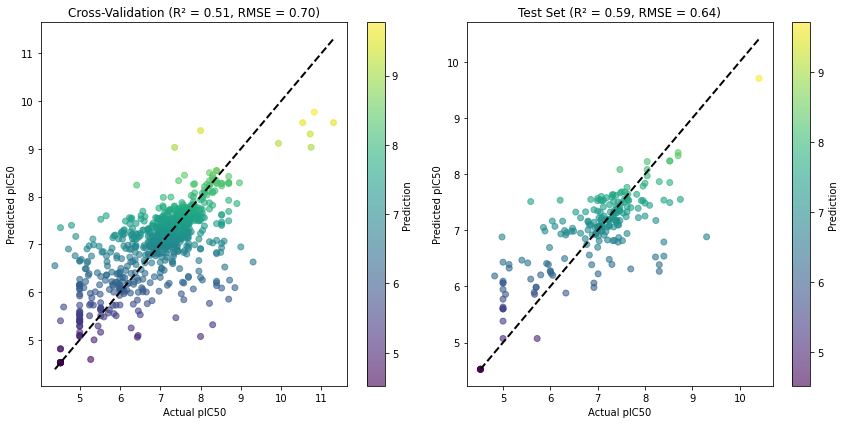

Loaded model test R^2 score: 0.5934990180966292
Loaded model test RMSE: 0.640214461859286


In [11]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(30)

# 读取CSV文件
df = pd.read_csv('/home/szy/proj/crf/CDK9/CDK9.csv')

# 将SMILES字符串转换为分子对象
ms = [Chem.MolFromSmiles(x) for x in df['smiles']]

# 过滤掉无效的分子
valid_mols = [mol for mol in ms if mol is not None]
valid_indices = [i for i, mol in enumerate(ms) if mol is not None]
df = df.iloc[valid_indices]

# 创建新列来保存RDKit指纹
df['RDKit_FP'] = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in valid_mols]

with open('rdkit_fingerprints.pkl', 'wb') as f:
    pickle.dump(df['RDKit_FP'].values, f)

# Save labels
with open('labels.pkl', 'wb') as f:
    pickle.dump(df['pIC50'].values, f)

with open('rdkit_fingerprints.pkl', 'rb') as f:
    rdkit_fingerprints = pickle.load(f)

# Load labels
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

rdkit_fingerprints = np.array(list(rdkit_fingerprints))

# Split to separate out the training and test set
X_train, X_test, y_train, y_test = train_test_split(rdkit_fingerprints, labels, test_size=0.2, random_state=42)

# Train k-NN model with 5-fold cross-validation
model = KNeighborsRegressor(n_neighbors=5)

# Define RMSE as scoring metric
scoring = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and print results
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
print(f"Cross-Validation RMSE scores: {cv_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(cv_scores)}")
print(f"Standard Deviation Cross-Validation RMSE: {np.std(cv_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate R^2 score
cv_r2 = r2_score(y_train, cv_predictions)
print(f"Cross-Validation R² score: {cv_r2}")

# Train final model on the entire training set
model.fit(X_train, y_train)

# Save the model using pickle
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Predict on test set
predictions = model.predict(X_test)

# Calculate and print test set R^2 score
test_r2 = r2_score(y_test, predictions)
print("Test R^2 score: ", test_r2)

# Calculate and print test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse_test}")

# Plotting
plt.figure(figsize=(12, 6))

# Cross-validation plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, cv_predictions, c=cv_predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Cross-Validation (R² = {cv_r2:.2f}, RMSE = {np.mean(cv_scores):.2f})')
plt.colorbar(label='Prediction')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, c=predictions, cmap='viridis', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {test_r2:.2f}, RMSE = {rmse_test:.2f})')
plt.colorbar(label='Prediction')

plt.tight_layout()
plt.show()

# Load the model using pickle (if needed)
with open('knn_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify loaded model predictions
loaded_predictions = loaded_model.predict(X_test)
print(f"Loaded model test R^2 score: {r2_score(y_test, loaded_predictions)}")
print(f"Loaded model test RMSE: {np.sqrt(mean_squared_error(y_test, loaded_predictions))}")
